<a href="https://colab.research.google.com/github/andres4640/Fake-News-Tesis/blob/main/Copia_de_FakeNews_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News

El dataset "COVID Fake News Data.csv" fue extraido de la siguiente dirección: https://zenodo.org/record/4282522#.YJ6FtsCg9Pa

El dataset "fake_new_dataset.xlsx" se obtuvo de la siguiente dirección: https://data.mendeley.com/datasets/zwfdmp5syg/1

Ambos datasets cuentan con columnas que indican si el texto es falso o verdadero. En el caso del primer dataset, la columna "outcome" representa la veracidad del texto y en el segundo dataset, la columna "label". En ambas columnas, el valor "0" representa veracidad y "1" falsedad.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/Tesis/')

In [4]:
df_one = pd.read_csv("Datasets/COVID Fake News Data.csv")
df_two = pd.read_excel("Datasets/fake_new_dataset.xlsx", index_col = None)

Limpiar los caracteres que no son ASCII:

In [5]:
df_one.outcome.value_counts()

0    9727
1     474
Name: outcome, dtype: int64

In [6]:
df_two.label.value_counts()

1    2061
0    1058
Name: label, dtype: int64

In [7]:
from string import printable

df_one.headlines = df_one.headlines.apply(lambda y: ''.join(filter(lambda x: 
            x in printable, y)))

In [8]:
df_one.outcome.replace({0: 1, 1: 0}, inplace=True)
df_one.outcome.value_counts()

1    9727
0     474
Name: outcome, dtype: int64

In [9]:
df_two.label.replace({0: 1, 1: 0}, inplace=True)
df_two.label.value_counts()

0    2061
1    1058
Name: label, dtype: int64

En el segundo dataset modificamos el nombre de las columnas para poder concatenarlo con el primer dataset

In [10]:
df_two.rename(columns={"title": "headlines", "label": "outcome"}, inplace=True)

Concatenamos el dataset

In [11]:
df_one_final = pd.concat([df_one, df_two[["headlines", "outcome"]]], ignore_index=True)

Podemos ver la diferencia de numero de datos entre ambas clases, hay una mayor cantidad de textos clasificados como falsos. Esto representa un desbalance de clases.

In [12]:
df_one_final.outcome.value_counts()

1    10785
0     2535
Name: outcome, dtype: int64

Podemos ver que existe un dato que tiene valor nulo en la columna "headlines". Eliminaremos este dato, no afectara al entrenamiento debido a su numero reducido.

In [13]:
df_one_final.isna().sum()

headlines    1
outcome      0
dtype: int64

In [14]:
df_one_final.dropna(inplace=True)
df_one_final.reset_index(drop=True, inplace=True)

Analizamos cuantas palabras tienen como maximo, minimo y promedio las oraciones que se usaran para entrenar el modelo.

In [15]:
# Maximo largo de una palabra antes del reproceso
print("Largo oracion Maximo ",df_one_final.headlines.str.len().max())
print("Largo oracion Minimo: ",df_one_final.headlines.str.len().min())
print("Largo oracion Promedio: ",df_one_final.headlines.str.len().mean())

Largo oracion Maximo  673
Largo oracion Minimo:  6
Largo oracion Promedio:  93.10751557924769


## Preprocesamiento de textos

Vemos el tamaño del dataset es de 13319 datos:

In [16]:
len(df_one_final)

13319

Importamos la libreria NLTK que nos permitira aplicar tecnicas de procesamiento de lenguaje natural (NLP) en los textos:

In [17]:
import re
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Aplicaremos tecnicas de pre procesamiento de textos como convertir palabras a minuscula, eliminar espacios y caracteres innecesarios, y aplicar la técnica Stemming. Como resultado obtendremos el cuerpo de los textos pre procesados para entrenar los modelos.

In [18]:
corpus = []
lista_palabras = []
for i in range(len(df_one_final)):
  # Reemplazamos caracteres innecesarios como puntos y comas:
  #texto = re.sub("[^a-zA-Z-á-é-í-ó-ú]", " ", df_one_final["headlines"][i])
  texto = re.sub("[^a-zA-Z]", " ", df_one_final["headlines"][i])

  # Eliminamos espacios extras
  texto = re.sub(r"\s+"," ", texto, flags = re.I)

  # Convertimos el texto a minuscula:
  texto = texto.lower()

  # Dividimos el texto en palabras individuales:
  texto = texto.split()

  # Declaramos el objeto Stemming:
  stemmer = PorterStemmer()

  # Excluimos los Stop Words de los textos:
  lista_stopwords = stopwords.words("english")
  
  # Aplicamos Stemming y omitimos los Stop words:
  texto = [stemmer.stem(palabra) for palabra in texto if not palabra in set(lista_stopwords)]

  lista_palabras.append(texto)
  
  # Unimos las palabras, separados por un espacio:
  texto= " ".join(texto)

  # Añadimos el texto al corpus
  corpus.append(texto)

Creamos una funcioón para conocer el numero de palabras en el corpus:

In [19]:
def num_palabras(corp):
  palabras_unicas = []
  lista_palabras = []
  for lista in corpus:
    lista_palabras = lista.split()
    for palabra in lista_palabras:
      if palabra not in palabras_unicas:
        palabras_unicas.append(palabra)
  return len(palabras_unicas)

In [20]:
tamanio_voc = num_palabras(corpus)

## Desarrollo del Modelo

In [22]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

### Word2Vec

Descargamos el modelo pre entrenado Word2Vec, el cual se entreno con un corpus de Google News de aproximadamente 3 billones de palabras. Estas se encuentran representado como vectores de 300 dimensiones.

In [23]:
pip install gensim

In [24]:
from tensorflow.keras.utils import get_file
modelo_pre_entrenado = 0
if modelo_pre_entrenado == 1:
  path = get_file('GoogleNews-vectors-negative300.bin.gz', 
  origin='https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
  print(path)

In [25]:
from gensim.models import word2vec
# Modelo word2vec usando la arquitectura CBOW:
model_word2vec_cbow = word2vec.Word2Vec(corpus, size=100, window=5, min_count=5, workers=12, sg=0)
#w2v_pesos_cbow = model_word2vec_cbow.wv.vectors

model_word2vec_skip = word2vec.Word2Vec(corpus, size=100, window=5, min_count=5, workers=12, sg=0)
#w2v_pesos_skip = model_word2vec_skip.wv.vectors

### Padding

Se aplica la tecnica de padding para que todas los textos tengan el mismo largo.

In [26]:
def largo_max(corp):
  max_valor = 0
  for lista in corp:
    largo = len(lista)
    if largo > max_valor:
      max_valor = largo
  return max_valor

Tokenizamos las palabras del corpus para que puedan ser leidos por el modelo y aplicamos la tecnica llamada padding para que todas las oraciones ingresantes en el modelo de redes neuronales tengan el mismo tamaño.

In [47]:
def tokenizar_padding(corpus_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus_data)
  secuencias = tokenizer.texts_to_sequences(corpus_data)
  max_len_oracion = largo_max(secuencias)
  resultado = pad_sequences(secuencias, maxlen = max_len_oracion)
  return resultado, max_len_oracion


In [48]:
X, max_largo_oracion = tokenizar_padding(corpus)

In [31]:
embedding_vector_size = 100
def matriz_pesos_word2vec(modelo_word2vec, corpus_data):
  voc_size = num_palabras(corpus_data)
  words = list(modelo_word2vec.wv.vocab)
  embedding_matrix = np.zeros((voc_size+1, embedding_vector_size))
  for index, word in enumerate(words):    
    embedding_vector = modelo_word2vec.wv[word]
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [32]:
embedding_matrix_cbow = matriz_pesos_word2vec(model_word2vec_cbow, corpus)
embedding_matrix_skip = matriz_pesos_word2vec(model_word2vec_skip, corpus)

## Modelo LSTM y Word2

In [75]:
def LSTM_Word2Vec(matriz_embedding, num_neuronas):
  model=Sequential()
  model.add(Embedding(tamanio_voc+1, embedding_vector_size, input_length=max_largo_oracion, weights = [matriz_embedding]))
  model.add(LSTM(num_neuronas, dropout=0.2, recurrent_dropout=0.2))
  model.add(Dense(1,activation='sigmoid'))
  return model

In [76]:
LSTM_Word2vec_cbow = LSTM_Word2Vec(embedding_matrix_cbow, 100)
LSTM_Word2vec_cbow.compile(loss ='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(LSTM_Word2vec_cbow.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 100)           943900    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,024,401
Trainable params: 1,024,401
Non-trainable params: 0
_________________________________________________________________
None


In [77]:
LSTM_Word2vec_skip = LSTM_Word2Vec(embedding_matrix_skip, 100)
LSTM_Word2vec_skip.compile(loss ='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(LSTM_Word2vec_skip.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 64, 100)           943900    
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,024,401
Trainable params: 1,024,401
Non-trainable params: 0
_________________________________________________________________
None


## Modelo LSTM y BERT

Usaremos el modelo BERT Base.

Link: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4

In [41]:
!pip install tensorflow-text

     |████████████████████████████████| 4.3MB 5.2MB/s 


In [42]:
import tensorflow_hub as hub
from tensorflow.keras import layers
import tensorflow_text as text
urL_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4" #tfhub_handle_encoder 
preprocesador =  "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" #tfhub_handle_preprocess 

In [137]:
def LSTM_BERT(num_neuronas):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocesador, name='Preprocesamiento')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(urL_bert, trainable=True, name='Codificador_BERT')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  #net = tf.keras.layers.Dense(96, activation="relu") (net)
  #net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.expand_dims(net, axis=-1)
  net = tf.keras.layers.LSTM(num_neuronas, dropout=0.2, recurrent_dropout=0.2, name='Capa_LSTM')(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='Clasificador')(net)
  return tf.keras.Model(text_input, net)

In [138]:
LSTM_BERT_modelo = LSTM_BERT(100)

In [ ]:
tf.keras.utils.plot_model(LSTM_BERT_modelo)

In [126]:
LSTM_BERT_modelo.compile(loss ='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(LSTM_BERT_modelo.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
Preprocesamiento (KerasLayer)   {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
Codificador_BERT (KerasLayer)   {'encoder_outputs':  109482241   Preprocesamiento[0][0]           
                                                                 Preprocesamiento[0][1]           
                                                                 Preprocesamiento[0][2]           
____________________________________________________________________________________________

# Dividir Dataset

In [79]:
y = np.array(df_one_final.outcome)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Desbalanceo del dataset

Aplicaremos una combinación de tecnicas de Undersampling y Oversampling para poder tener reducir el desbalance del dataset.

Undersampling -> Reduce el número de la clase mayoritaria al azar a la proporción deseada contra la clase minoritaria. 

OverSampling -> Duplicamos los datos que tienen la clase minoritaria o creamos nuevos ejemplos sinteticos. En el caso de un dataset de texto, no recomendable crear ejemplos.

In [80]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

over = RandomOverSampler(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
print("Antes de aplicar las tecnicas: ", Counter(y_train))
X_train, y_train = over.fit_resample(X_train, y_train)
print("Despues de aplicar Oversampling: ", Counter(y_train))
X_train, y_train = under.fit_resample(X_train, y_train)
print("Despues de aplicar Undersampling: ", Counter(y_train))

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Antes de aplicar las tecnicas:  Counter({1: 8627, 0: 2028})
Despues de aplicar Oversampling:  Counter({1: 8627, 0: 3450})
Despues de aplicar Undersampling:  Counter({1: 6900, 0: 3450})


# Entrenar Modelos

In [81]:
LSTM_Word2vec_cbow.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64)

Epoch 1/10
162/162 [==============================] - 37s 210ms/step - loss: 0.3484 - accuracy: 0.8501 - val_loss: 0.1713 - val_accuracy: 0.9400
Epoch 2/10
162/162 [==============================] - 33s 207ms/step - loss: 0.1568 - accuracy: 0.9401 - val_loss: 0.1103 - val_accuracy: 0.9643
Epoch 3/10
162/162 [==============================] - 34s 208ms/step - loss: 0.1083 - accuracy: 0.9611 - val_loss: 0.0808 - val_accuracy: 0.9744
Epoch 4/10
162/162 [==============================] - 33s 205ms/step - loss: 0.0816 - accuracy: 0.9729 - val_loss: 0.0589 - val_accuracy: 0.9812
Epoch 5/10
162/162 [==============================] - 35s 214ms/step - loss: 0.0677 - accuracy: 0.9768 - val_loss: 0.0544 - val_accuracy: 0.9832
Epoch 6/10
162/162 [==============================] - 34s 208ms/step - loss: 0.0587 - accuracy: 0.9796 - val_loss: 0.0428 - val_accuracy: 0.9861
Epoch 7/10
162/162 [==============================] - 34s 208ms/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 0.0427 - val_ac

In [82]:
LSTM_Word2vec_skip.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64)

Epoch 1/10
162/162 [==============================] - 38s 218ms/step - loss: 0.3398 - accuracy: 0.8538 - val_loss: 0.1620 - val_accuracy: 0.9414
Epoch 2/10
162/162 [==============================] - 35s 217ms/step - loss: 0.1599 - accuracy: 0.9403 - val_loss: 0.1115 - val_accuracy: 0.9609
Epoch 3/10
162/162 [==============================] - 33s 206ms/step - loss: 0.1093 - accuracy: 0.9615 - val_loss: 0.0753 - val_accuracy: 0.9756
Epoch 4/10
162/162 [==============================] - 33s 205ms/step - loss: 0.0828 - accuracy: 0.9721 - val_loss: 0.0619 - val_accuracy: 0.9814
Epoch 5/10
162/162 [==============================] - 33s 206ms/step - loss: 0.0668 - accuracy: 0.9786 - val_loss: 0.0507 - val_accuracy: 0.9843
Epoch 6/10
162/162 [==============================] - 33s 206ms/step - loss: 0.0587 - accuracy: 0.9802 - val_loss: 0.0450 - val_accuracy: 0.9851
Epoch 7/10
162/162 [==============================] - 34s 211ms/step - loss: 0.0547 - accuracy: 0.9824 - val_loss: 0.0427 - val_ac

In [87]:
X_train.shape[1]

64

In [130]:
LSTM_BERT_modelo.fit(X_train,y_train,epochs=10,batch_size=64)

Epoch 1/10


ValueError: ignored

In [141]:
y_pred_cbow = LSTM_Word2vec_cbow.predict(X_test)
y_pred_skip = LSTM_Word2vec_skip.predict(X_test)

In [148]:
def clasificar(y_data):
  y_pred_final = []
  y_pred_lista = []
  for x in y_data:
    for y in x:
      y_pred_lista.append(y)
      if y >= 0.5:
        y_pred_final.append(1)
      else:
        y_pred_final.append(0)
  return np.array(y_pred_final), np.array(y_pred_lista)

In [149]:
y_final_cbow, y_probs_cbow = clasificar(y_pred_cbow)
y_final_skip, y_probs_skip = clasificar(y_pred_skip)

# Metricas de Clasificación

## Matriz de confusión

In [165]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def evaluar_modelo(y_pred, nombre):
    plt.figure(figsize=(10,5))
    matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         matrix.flatten()/np.sum(matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title(nombre)
    plt.show()
    
    print("\nAccuracy: ", accuracy)

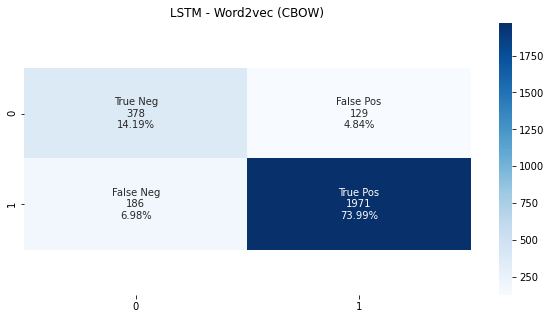


Accuracy:  0.8817567567567568


In [166]:
evaluar_modelo(y_final_cbow, 'LSTM - Word2vec (CBOW)')

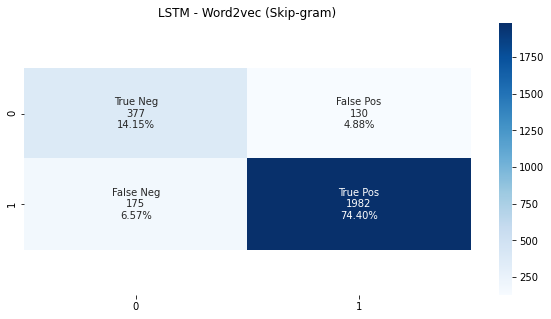


Accuracy:  0.8855105105105106


In [167]:
evaluar_modelo(y_final_skip, 'LSTM - Word2vec (Skip-gram)')

## Recall:

In [152]:
from sklearn.metrics import recall_score
recall_score(y_test, y_final_cbow, average='macro')

0.8296656269802734

In [153]:
recall_score(y_test, y_final_skip, average='macro')

0.8312292714239864

## ROC Curve:

In [ ]:
y_pred_lista

array([0.99998116, 0.9999986 , 0.9996464 , ..., 0.9999142 , 0.0317044 ,
       0.9506495 ], dtype=float32)

In [163]:
# y_pred
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
redes_cbow = y_probs_cbow
redes_skip = y_probs_skip
#redes_probs = redes_probs#[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
cbow_auc = roc_auc_score(y_test, redes_cbow)
skip_auc = roc_auc_score(y_test, redes_skip)


print('Predicción aleatoria: AUROC = %.3f' % (r_auc))
print('Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = %.3f' % (cbow_auc))
print('Modelo Red Neuronal LSTM Word2vec SKIP: AUROC = %.3f' % (skip_auc))

Predicción aleatoria: AUROC = 0.500
Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = 0.915
Modelo Red Neuronal LSTM Word2vec SKIP: AUROC = 0.915


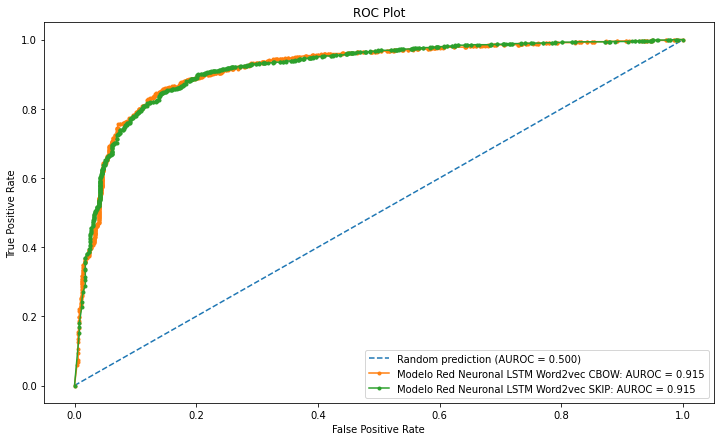

In [164]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
cbow_fpr, cbow_tpr, _ = roc_curve(y_test, redes_cbow)
skip_fpr, skip_tpr, _ = roc_curve(y_test, redes_skip)
plt.figure(figsize=(12,7))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(cbow_fpr, cbow_tpr, marker='.', label='Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = %.3f' % cbow_auc)
plt.plot(skip_fpr, skip_tpr, marker='.', label='Modelo Red Neuronal LSTM Word2vec SKIP: AUROC = %.3f' % skip_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()